<a href="https://colab.research.google.com/github/Avipsa1/UPPP275-Notebooks/blob/main/Exploratory_spatial_data_analysis_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import seaborn as sns
from scipy.stats import stats

np.random.seed(0)

In [6]:
# load CA tracts, display shape
tracts_ca = gpd.read_file('tl_2017_06_tract.shp')
tracts_ca = tracts_ca.set_index('GEOID')
tracts_ca.shape

(8057, 12)

In [7]:
# what variables are present?
tracts_ca.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [8]:
# inspect the first 5 rows
tracts_ca.head()

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID,,,,,,,,,,,,
06001442700,06,001,442700,4427,Census Tract 4427,G5020,S,1234034,0,+37.5371514,-122.0081094,"POLYGON ((-122.01721 37.53932, -122.01719 37.5..."
06001442800,06,001,442800,4428,Census Tract 4428,G5020,S,1278647,0,+37.5293619,-121.9931002,"POLYGON ((-122.00230 37.52984, -122.00224 37.5..."
06037204920,06,037,204920,2049.20,Census Tract 2049.20,G5020,S,909972,0,+34.0175004,-118.1974975,"POLYGON ((-118.20284 34.01966, -118.20283 34.0..."
06037205110,06,037,205110,2051.10,Census Tract 2051.10,G5020,S,286962,0,+34.0245059,-118.2142985,"POLYGON ((-118.21963 34.02629, -118.21945 34.0..."
06037205120,06,037,205120,2051.20,Census Tract 2051.20,G5020,S,1466129,0,+34.0187546,-118.2117956,"POLYGON ((-118.22023 34.02056, -118.22018 34.0..."


In [9]:
# retain LA county only (and drop channel island tracts)
tracts_ca = tracts_ca[tracts_ca['COUNTYFP']=='037'].drop(index=['06037599100', '06037599000'])
tracts_ca.shape

(2344, 12)

In [10]:
# project spatial geometries to a meter-based projection for SoCal
crs = '+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
tracts_ca = tracts_ca.to_crs(crs)

In [11]:
# load CA tract-level census variables
df_census = pd.read_csv('census_tracts_data_ca.csv', dtype={'GEOID10':str}).set_index('GEOID10')
df_census.shape

(8057, 27)

In [12]:
df_census.columns

Index(['total_pop', 'median_age', 'pct_hispanic', 'pct_white', 'pct_black',
       'pct_asian', 'pct_male', 'pct_single_family_home', 'med_home_value',
       'med_rooms_per_home', 'pct_built_before_1940', 'pct_renting',
       'rental_vacancy_rate', 'avg_renter_household_size', 'med_gross_rent',
       'med_household_income', 'mean_commute_time', 'pct_commute_drive_alone',
       'pct_below_poverty', 'pct_college_grad_student',
       'pct_same_residence_year_ago', 'pct_bachelors_degree',
       'pct_english_only', 'pct_foreign_born', 'state', 'county',
       'county_name'],
      dtype='object')

In [13]:
df_census.head()

,total_pop,median_age,pct_hispanic,pct_white,pct_black,pct_asian,pct_male,pct_single_family_home,med_home_value,med_rooms_per_home,...,pct_commute_drive_alone,pct_below_poverty,pct_college_grad_student,pct_same_residence_year_ago,pct_bachelors_degree,pct_english_only,pct_foreign_born,state,county,county_name
GEOID10,,,,,,,,,,,,,,,,,,,,,
06001437701,3745.0,29.4,59.6,11.7,9.9,303.0,49.7,19.2,310700.0,4.0,...,64.3,11.9,15.7,93.8,11.5,35.5,38.6,6,1,Alameda
06001437102,4586.0,36.6,34.2,10.1,8.5,1813.0,45.8,28.0,384400.0,4.8,...,78.1,10.4,45.5,91.2,22.0,32.9,48.8,6,1,Alameda
06001437101,7186.0,40.2,20.6,13.9,5.9,3623.0,49.4,76.1,582400.0,5.9,...,75.6,3.1,34.5,90.0,40.0,46.1,42.3,6,1,Alameda
06001450752,5854.0,38.4,8.0,22.7,4.3,3514.0,51.2,80.5,1008600.0,7.8,...,60.1,1.4,15.9,94.5,65.7,44.2,44.5,6,1,Alameda
06001450751,8963.0,36.7,4.8,22.4,1.2,6020.0,48.7,77.4,922500.0,6.6,...,59.3,2.7,10.9,78.8,78.4,35.8,50.1,6,1,Alameda


In [14]:
# merge tract geometries with census variables
tracts = tracts_ca.merge(df_census, left_index=True, right_index=True, how='left')
tracts.shape

(2344, 39)

In [15]:
# calculate pop density in persons per sq km
# turn any infinities into nulls
tracts['pop_density'] = tracts['total_pop'] / (tracts['ALAND'] / 1e6)
tracts = tracts.replace([np.inf, -np.inf], np.nan)

In [16]:
tracts.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'total_pop', 'median_age', 'pct_hispanic', 'pct_white', 'pct_black',
       'pct_asian', 'pct_male', 'pct_single_family_home', 'med_home_value',
       'med_rooms_per_home', 'pct_built_before_1940', 'pct_renting',
       'rental_vacancy_rate', 'avg_renter_household_size', 'med_gross_rent',
       'med_household_income', 'mean_commute_time', 'pct_commute_drive_alone',
       'pct_below_poverty', 'pct_college_grad_student',
       'pct_same_residence_year_ago', 'pct_bachelors_degree',
       'pct_english_only', 'pct_foreign_born', 'state', 'county',
       'county_name', 'pop_density'],
      dtype='object')

In [17]:
# descriptive stats
tracts['med_household_income'].describe()

count      2306.000000
mean      66214.160017
std       32494.553182
min        5682.000000
25%       41781.000000
50%       59409.500000
75%       82134.000000
max      250001.000000
Name: med_household_income, dtype: float64

In [18]:
# descriptive stats
tracts['pop_density'].describe()

count     2341.000000
mean      5205.656863
std       4367.637858
min          0.000000
25%       2462.185064
50%       4166.181621
75%       6740.945723
max      37828.469314
Name: pop_density, dtype: float64

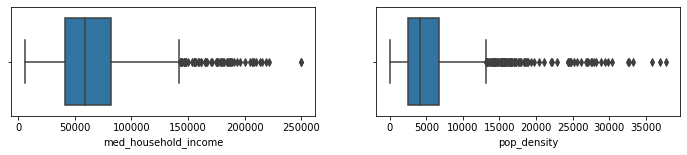

In [19]:
# inspect these variables' statistical distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 2))
ax1 = sns.boxplot(ax=axes[0], x=tracts['med_household_income'])
ax2 = sns.boxplot(ax=axes[1], x=tracts['pop_density'])

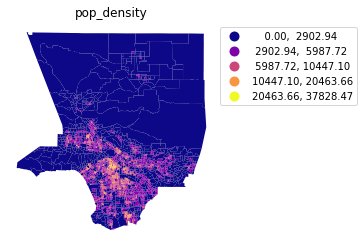

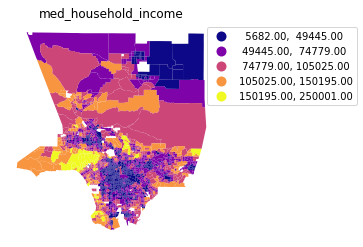

In [20]:
# map a couple variables to inspect their spatial distributions
cols = ['pop_density', 'med_household_income']
for col in cols:
    ax = tracts.dropna(subset=[col]).plot(column=col,
                                          scheme='NaturalBreaks',
                                          cmap='plasma',
                                          figsize=(4, 4),
                                          legend=True,
                                          legend_kwds={'bbox_to_anchor': (1.7, 1)})
    ax.set_title(col)
    _ = ax.axis('off')

In [21]:
# calculate correlation coefficient and p-value
subset = tracts.dropna(subset=['pop_density', 'med_household_income'])
r, p = stats.pearsonr(x=subset['pop_density'],
                      y=subset['med_household_income'])
print('r={:.4f}, p={:.4f}'.format(r, p))

r=-0.5016, p=0.0000


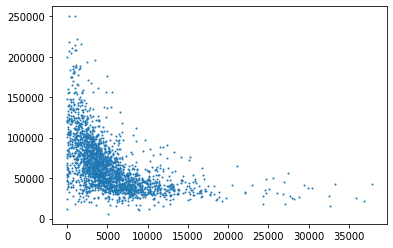

In [22]:
# quick and dirty scatter plot with matplotlib
fig, ax = plt.subplots()
sc = ax.scatter(x=subset['pop_density'],
                y=subset['med_household_income'],
                s=1)

In [23]:
# estimate a simple linear regression model with scipy
# what if you log transform your variables first?
m, b, r, p, se = stats.linregress(x=subset['pop_density'],
                                  y=subset['med_household_income'])
print(f'm={m:.4f}, b={b:.4f}, r^2={r**2:.4f}, p={p:.4f}')

m=-3.7386, b=85940.4814, r^2=0.2516, p=0.0000


In [ ]:
# now it's your turn
# look through the list of columns, pick two new variables, and map them
# do they look like they are correlated? would you expect them to be?